In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import ttest_ind
import statsmodels.stats.power as smp
from sklearn.model_selection import train_test_split

In [2]:
df_processes=pd.read_csv("data/processes.csv",sep='\t')
df_connections = pd.read_csv("data/connections.csv", sep='\t')
df_processes.head()


,ts,imei,mwra,p.android.chrome,p.android.externalstorage,p.android.gm,p.android.packageinstaller,p.android.settings,p.android.documentsui,p.system,...,p.inputmethod.latin,p.android.vending,p.notifier,p.katana,p.browser.provider,p.olauncher,p.process.gapps,p.google,p.android.defcontainer,p.dogalize
0,2018-05-05 10:00:00,359043379931766817,0.0,12.67131,11.51584,11.14770,16.65822,10.34567,13.85827,14.24441,...,67.41099,43.41425,76.85292,61.49504,83.84273,90.26474,64.52255,58.33299,53.62833,71.56538
1,2018-05-05 10:01:00,8630330696303481313,1.0,14.37083,10.40542,9.51907,16.41548,8.97598,13.02322,16.31514,...,63.46175,41.06191,96.50752,90.91460,28.28500,8.85422,51.89787,15.59966,73.88848,8.64346
2,2018-05-05 10:02:00,8630330696303482485,1.0,15.29793,11.57740,13.15840,11.13504,12.78871,15.33671,18.05368,...,61.37235,41.14340,14.49331,74.73880,4.18073,6.10243,44.94162,60.25186,74.62467,43.83823
3,2018-05-05 10:03:00,8630330696303481628,0.0,17.46341,11.75419,11.61736,12.61226,9.20242,11.43078,9.84154,...,43.42172,49.29721,21.64738,71.05116,62.98376,44.42369,51.61388,13.60374,19.42437,1.84968
4,2018-05-05 10:04:00,359043379931766957,0.0,10.87997,12.62410,13.19246,13.77152,15.48980,14.81432,14.67672,...,48.06657,70.43036,90.86824,42.66690,60.74888,50.69262,24.46560,70.89736,46.68829,36.31749


<Axes: >

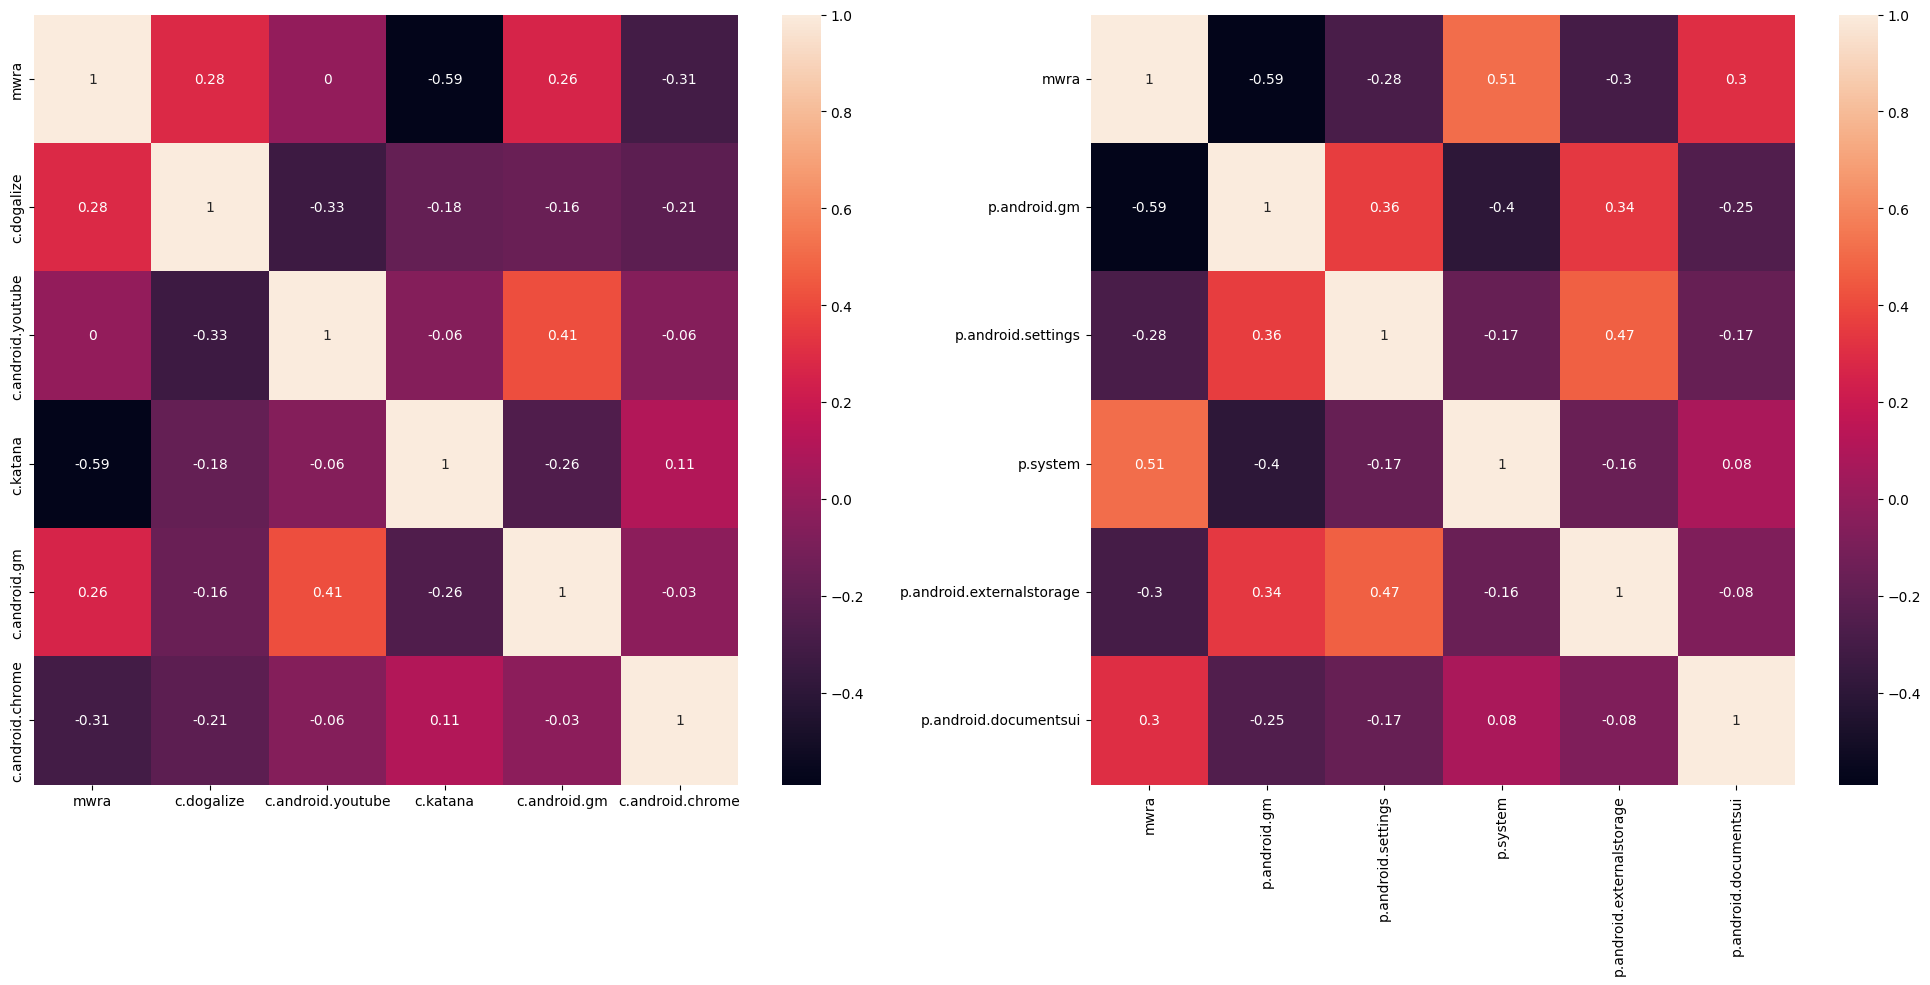

In [3]:
plt.figure(figsize=(25,10))
df_connections=df_connections[df_connections.columns[2:8]]
df_connections.drop_duplicates(inplace=True)
plt.subplot(1,2,1)
sns.heatmap(df_connections.iloc[:,:].corr().round(decimals=2),annot=True)
df_processes=df_processes[['mwra','p.android.gm','p.android.settings','p.system','p.android.externalstorage','p.android.documentsui']]

df_processes.drop_duplicates(inplace=True)
plt.subplot(1,2,2)
sns.heatmap(df_processes.iloc[:,:].corr().round(decimals=2),annot=True)


Removing outlier

In [4]:
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,14958.000000,14958.000000,14958.000000,14958.000000,14958.000000,14958.000000
mean,0.625552,12.219738,13.362260,13.301524,13.392167,13.914004
std,0.483996,2.416741,2.623566,2.770276,2.471792,2.471185
min,0.000000,3.492160,2.936040,2.605000,2.668370,5.614740
25%,0.000000,10.462042,11.693200,11.338778,11.798540,12.225840
50%,1.000000,11.991270,13.664550,13.338940,13.676970,14.008790
75%,1.000000,13.936673,15.216875,15.291855,15.168035,15.620772
max,1.000000,21.005110,21.756040,23.130130,23.066440,23.274340


for loop will iterate over every column and remove outlier will with help of identify outlier remove the outlier of said column by replacing it with its nearest quantile

In [5]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return (a > upper) | (a < lower)

def remove_outlier(df,column):
    outlier_mask = identify_outliers(df[column])
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    df.loc[outlier_mask, column] = np.where(
        df.loc[outlier_mask, column] < lower_bound,
        lower_bound,
        upper_bound
    )
    return df

for column in df_processes.columns:
    df_processes=remove_outlier(df_processes,column)
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,14958.000000,14958.000000,14958.000000,14958.000000,14958.000000,14958.000000
mean,0.625552,12.216396,13.380286,13.303942,13.407380,13.910515
std,0.483996,2.398087,2.561690,2.753045,2.418781,2.437519
min,0.000000,5.301570,6.409730,5.412460,6.746740,7.203720
25%,0.000000,10.462042,11.693200,11.338778,11.798540,12.225840
50%,1.000000,11.991270,13.664550,13.338940,13.676970,14.008790
75%,1.000000,13.936673,15.216875,15.291855,15.168035,15.620772
max,1.000000,19.099890,20.431470,21.192750,20.208530,20.681910


As can be observed , compared to the first df_connectoins.describe() the max/min values are way less extreme making it better suitable for ML

In [6]:
df_connections.describe()

,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome
count,14958.000000,14958.000000,14958.000000,14958.000000,14958.000000,14958.000000
mean,0.625552,12.146337,12.751739,12.210390,12.111509,11.561718
std,0.483996,2.610363,2.687584,2.427272,2.756517,2.371704
min,0.000000,2.568060,2.890720,2.437420,2.366610,0.000000
25%,0.000000,10.291533,10.826598,10.425388,10.182873,9.918893
50%,1.000000,12.043640,12.872705,12.004360,11.936870,11.418980
75%,1.000000,13.985978,14.725297,14.012107,13.911630,13.121467
max,1.000000,21.997370,21.469580,22.510050,22.667660,20.538700


In [7]:
for column in df_connections.columns:
    df_connections=remove_outlier(df_connections,column)
df_connections.describe()

,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome
count,14958.000000,14958.000000,14958.000000,14958.000000,14958.000000,14958.000000
mean,0.625552,12.145643,12.757332,12.204725,12.099878,11.555528
std,0.483996,2.589216,2.665831,2.403366,2.704281,2.317948
min,0.000000,4.789020,4.991870,5.127470,4.622840,5.131260
25%,0.000000,10.291533,10.826598,10.425388,10.182873,9.918893
50%,1.000000,12.043640,12.872705,12.004360,11.936870,11.418980
75%,1.000000,13.985978,14.725297,14.012107,13.911630,13.121467
max,1.000000,19.514050,20.560460,19.385140,19.490680,17.911160


In [8]:
df_processes_train, df_processes_test = train_test_split(df_processes, test_size=0.2, random_state=42)
print(df_processes_train.shape,df_processes_test.shape)

(11966, 6) (2992, 6)


In [9]:
df_connections_train, df_connections_test = train_test_split(df_connections, test_size=0.2, random_state=42)
print(df_connections_train.shape,df_connections_test.shape)


(11966, 6) (2992, 6)
